In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os
import datetime

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
(train, test), info = tfds.load("mnist", as_supervised=True, split=["train", "test"], with_info=True)

In [6]:
info.description

'The MNIST database of handwritten digits.'

In [7]:
info.features["label"].names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [8]:
print(f"Train set size is {train.__len__()}.")
print(f"Test set size is {test.__len__()}.")

Train set size is 60000.
Test set size is 10000.


In [9]:
@tf.function
def map_labels(label):
    return tf.one_hot(label, 10)

def decode_label(one_hots):
    return int(tf.argmax(one_hots, axis=0))

def preprocess(features, labels):
    # features = tf.where(features == 0, 0., 1.)
    features = tf.cast(features, tf.float32) / 255.
    labels = map_labels(labels)
    return features, labels

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32

train_set = train.shuffle(1000).map(preprocess).repeat().batch(BATCH_SIZE).prefetch(AUTOTUNE)
validation_set = test.batch(BATCH_SIZE).map(preprocess).prefetch(AUTOTUNE) # use test_set as validation_set

STEPS_PER_EPOCH = train.__len__() / BATCH_SIZE

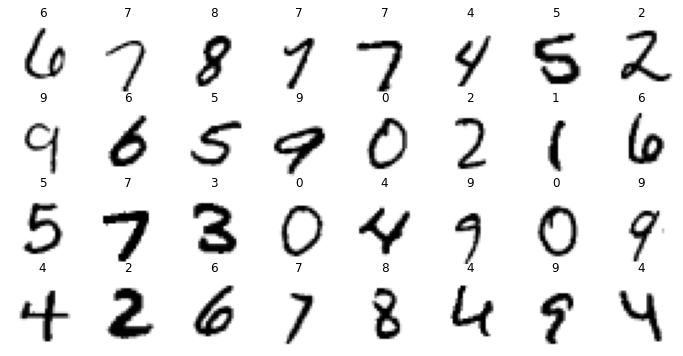

In [11]:
def plot_batch(x_b, y_b):
    i = 1
    plt.figure(figsize=(12, 6))
    for x_b, y_b in zip(x_b, y_b):
        plt.subplot(4, 8, i)
        plt.imshow(x_b, cmap="binary")
        plt.title(decode_label(y_b))
        plt.axis("off")
        i += 1
    plt.show()

for samples_x, samples_y in train_set.take(1):
    plot_batch(samples_x, samples_y)

In [12]:
# load samples
id_ = 0

x_custom_test = y_custom_test = None
while id_ < 100:
    path = os.path.join("samples", f"sample_{id_}.npy")
    sample = np.load(path)
    target = id_ % 10
    sample = sample[np.newaxis, ...]

    if x_custom_test is not None:
        x_custom_test = np.r_[x_custom_test, sample]
        y_custom_test = np.r_[y_custom_test, target]
    else:
        x_custom_test = sample
        y_custom_test = target
    id_ += 1

x_custom_test = x_custom_test[..., np.newaxis]
y_custom_test = tf.one_hot(y_custom_test, 10)

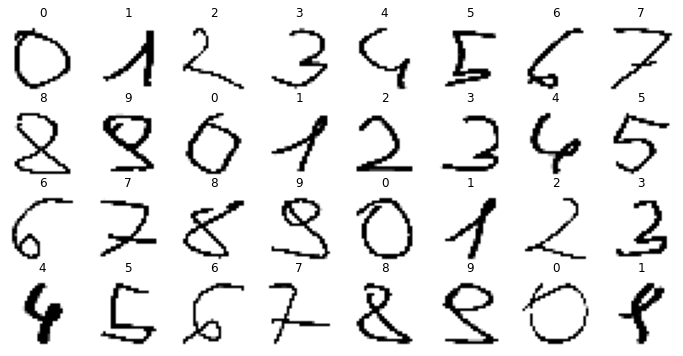

In [13]:
plot_batch(x_custom_test[:BATCH_SIZE], y_custom_test[:BATCH_SIZE])

In [14]:
model = keras.models.Sequential([
    keras.layers.Input(shape=[28, 28, 1]),

    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.LeakyReLU(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPool2D(pool_size=2, padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, kernel_size=3, padding="same"),
    keras.layers.LeakyReLU(),
    keras.layers.Conv2D(128, kernel_size=3, padding="same"),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPool2D(pool_size=2, padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=3, padding="same"),
    keras.layers.LeakyReLU(),
    keras.layers.Conv2D(256, kernel_size=3, padding="same"),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPool2D(pool_size=2, padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(512, kernel_size=3),
    keras.layers.LeakyReLU(),
    keras.layers.AvgPool2D(pool_size=2),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),

    keras.layers.Flatten(),
    keras.layers.Dense(512),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax"),
])

In [15]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       7

In [17]:
MODEL_FILE = "model3.h5"

log_dir = os.path.join(os.curdir, "logs", datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S"))

tensorbord_cb = keras.callbacks.TensorBoard(log_dir=log_dir, write_steps_per_second=True, histogram_freq=1, write_images=True, update_freq=10000)
earlystop_cb = keras.callbacks.EarlyStopping(patience=5, verbose=1)
save_cb = keras.callbacks.ModelCheckpoint(MODEL_FILE, save_best_only=True, verbose=1)
rp_cb = keras.callbacks.ReduceLROnPlateau(patience=3, min_lr=0.00001, verbose=1)

callbacks = [tensorbord_cb, earlystop_cb, save_cb, rp_cb]

In [18]:
# with tf.device('GPU:0'): # use gpu
history = model.fit(train_set, validation_data=validation_set, epochs=100, steps_per_epoch=STEPS_PER_EPOCH, callbacks=callbacks) # 100 epochs because it will stop earlier by callback

Epoch 1/100
1875/1875 [==============================] - 50s 23ms/step - loss: 0.1568 - accuracy: 0.9560 - val_loss: 0.1263 - val_accuracy: 0.9695s: 0.2853 - accuracy:  - ETA - ETA: 29s - loss - ETA: 26s - l - ETA: 24s - loss: 0.2253 - - ETA: 23s - loss: 0.2177 - accuracy: 0 -

Epoch 00001: val_loss improved from inf to 0.12631, saving model to model3.h5
Epoch 2/100
1875/1875 [==============================] - 44s 24ms/step - loss: 0.0751 - accuracy: 0.9792 - val_loss: 0.0409 - val_accuracy: 0.9880 acc - ETA: 23s - l

Epoch 00002: val_loss improved from 0.12631 to 0.04090, saving model to model3.h5
Epoch 3/100
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0642 - accuracy: 0.9823 - val_loss: 0.0394 - val_accuracy: 0.9881

Epoch 00003: val_loss improved from 0.04090 to 0.03944, saving model to model3.h5
Epoch 4/100
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0514 - accuracy: 0.9856 - val_loss: 0.0461 - val_accuracy: 0.9883

Epoch 00004: val

In [19]:
%load_ext tensorboard

In [20]:
model.save("final_model3.h5") # save last model as well

In [21]:
model.evaluate(x_custom_test, y_custom_test)

4/4 [==============================] - 0s 50ms/step - loss: 1.4268 - accuracy: 0.7400


[1.4268438816070557, 0.7400000095367432]

In [24]:
best_model = keras.models.load_model("model3.h5")

In [25]:
best_model.evaluate(x_custom_test, y_custom_test)

4/4 [==============================] - 1s 6ms/step - loss: 1.3299 - accuracy: 0.7300


[1.3298753499984741, 0.7300000190734863]